# **Land Value Prediction Model**
- Author: Kim Dohwan [@ehghks021203](https://github.com/ehghks021203)
- Date: 2023.09.10. ~
- Description: Land value prediction model with XGBoost.
------

## **Overview**
In this project, we developed a predictive model for estimating land value, utilizing the XGBoost algorithm.

### Key Steps:
**1. Load libraries & get data:**

**2. Data Analysis:**
- In-depth analysis of the collected dataset.

**3. Data Preprocessing:**
- Handling missing values, encoding categorical variables, and scaling numerical features.

**4. Model Training with XGBoost:**
- Utilizing the XGBoost algorithm for training the predictive model.

**5. Evaluation and Validation:**
- Assessing model performance using metrics like Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

**6. Hyperparameter Tuning:**
- Fine-tuning model parameters for optimization.

### **Load libraries & get data**

In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath('')))

from config import BASE_DIR

# progress bar
from tqdm import trange, notebook

# linear algebra
import numpy as np 

# data processing
import pandas as pd
pd.options.display.float_format = "{: .2f}".format

# data visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
sns.set(style="white", context="notebook", palette="deep")

# preprocessing
from sklearn.model_selection import train_test_split

# data analysis
from scipy.stats import kstest
from scipy.stats import skew, norm

# model
import xgboost as xgb

# model visualization
from xgboost import plot_importance
from pdpbox import info_plots

# model validation
from sklearn.metrics import mean_squared_error


In [2]:
# Load Train Dataset
# DATA_PATH = BASE_DIR + "/Data/DatasetWithoutCdData.csv"
DATA_PATH = BASE_DIR + "/Data/Dataset.csv"
df = pd.read_csv(DATA_PATH)

In [3]:
# PNU 코드 자료형 object로 변경
df["PNU"] = df["PNU"].astype("str")
# PNU 코드를 시/도, 시/군/구, 읍/면/동, 리로 분할
df.insert(loc=1,column="Sido",value=df["PNU"].str.slice(0, 2).astype("object"))
#df.insert(loc=2,column="Sigungu",value=df["PNU"].str.slice(2, 5).astype("object"))
#df.insert(loc=3,column="Eupmyeondong",value=df["PNU"].str.slice(5, 8).astype("object"))
#df.insert(loc=4,column="Ri",value=df["PNU"].str.slice(8, 10).astype("object"))
df.insert(loc=2,column="LdCode",value=df["PNU"].str.slice(0, 10).astype("object"))
df.drop(["PNU"], axis=1, inplace=True)

### **Data analysis**

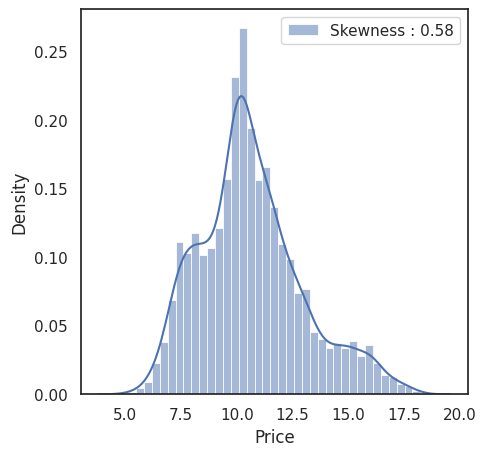

In [4]:
# target frature에 대한 분석
plt.subplots(figsize=(5, 5))
g = sns.histplot(
    np.log1p(df["Price"]),   # 가격 편차가 크기 때문에 log scaling을 해줌
    kde=True,
    stat="density",
    kde_kws=dict(cut=3),
    label = "Skewness : %.2f"%(np.log1p(df["Price"]).skew())
)
g = g.legend(loc="best")

<Axes: ylabel='Price'>

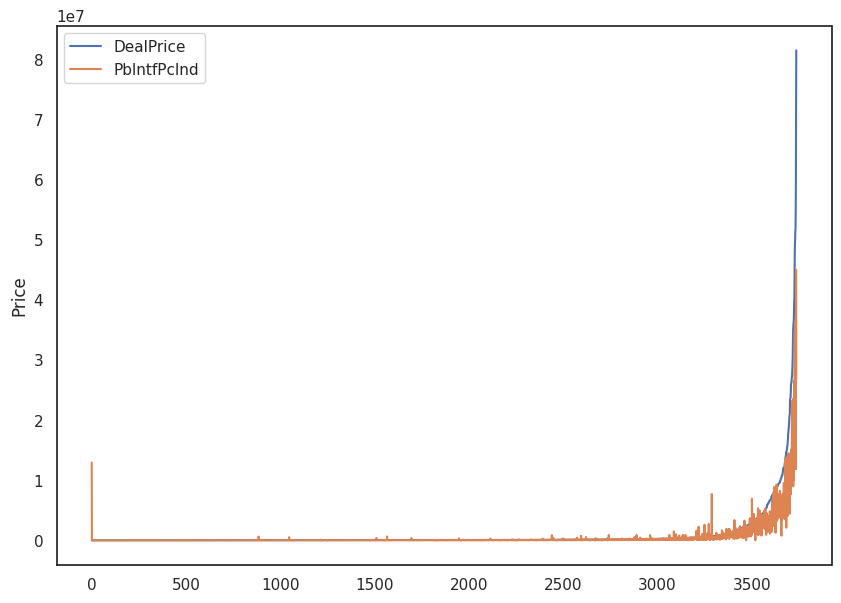

In [5]:
df_price = df[["Price", "PblntfPclnd"]]
df_price = df_price.sort_values("Price").reset_index(drop=True)

plt.subplots(figsize=(10, 7))
sns.lineplot(df_price["Price"], label="DealPrice")
sns.lineplot(df_price["PblntfPclnd"], label="PblntfPclnd")


<Axes: ylabel='Price'>

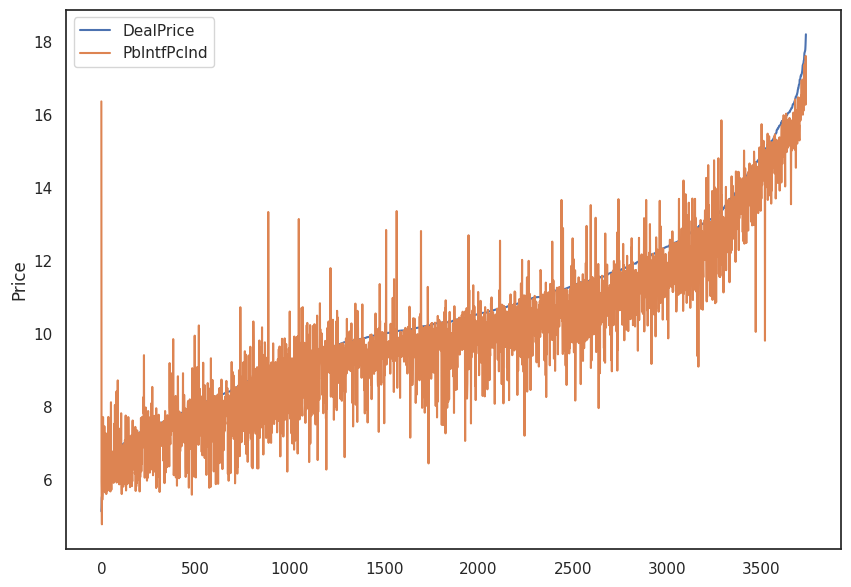

In [6]:
plt.subplots(figsize=(10, 7))
sns.lineplot(np.log1p(df_price["Price"]), label="DealPrice")
sns.lineplot(np.log1p(df_price["PblntfPclnd"]), label="PblntfPclnd")

## **Remove Outlier**

<Axes: xlabel='difference'>

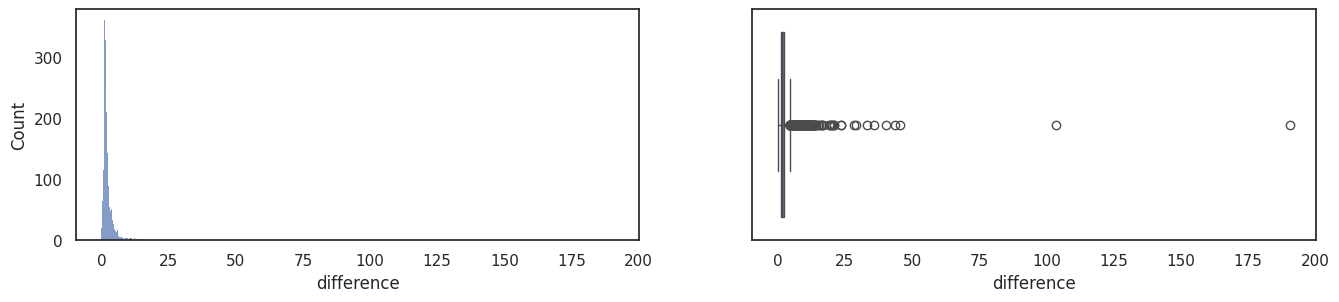

In [7]:
df["difference"] = abs(df["Price"]/df["PblntfPclnd"])

fig, axes = plt.subplots(1, 2, figsize=(16, 3))

sns.histplot(x=df["difference"], ax=axes[0])
sns.boxplot(x=df["difference"], ax=axes[1])

In [8]:
df["difference"].describe()

count    3737.00
mean        2.38
std         4.35
min         0.00
25%         1.16
50%         1.64
75%         2.47
max       190.71
Name: difference, dtype: float64

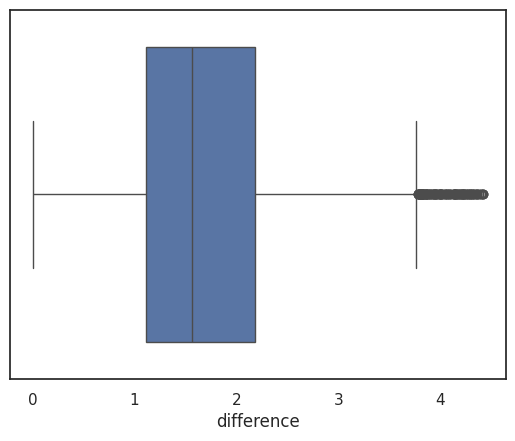

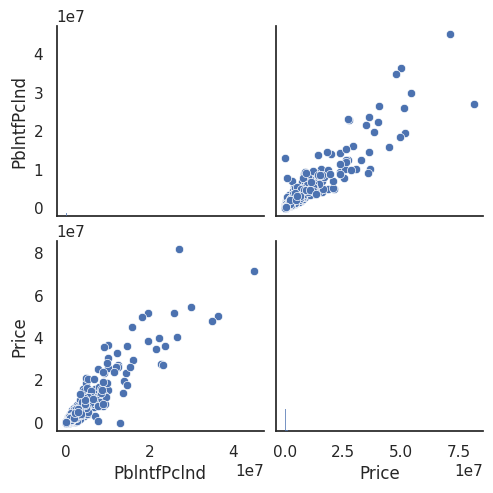

In [9]:
weight = 1.5

quantile_25 = np.percentile(df["difference"].values, 25)
quantile_75 = np.percentile(df["difference"].values, 75)

IQR = quantile_75 - quantile_25
IQR_weight = IQR*weight
  
lowest = quantile_25 - IQR_weight
highest = quantile_75 + IQR_weight

df = df[df["difference"].between(lowest, highest)]
sns.boxplot(x=df["difference"])
df = df.drop(["difference"], axis=1)

sns.pairplot(df, vars=["PblntfPclnd", "Price"])
plt.show()

<Axes: ylabel='Price'>

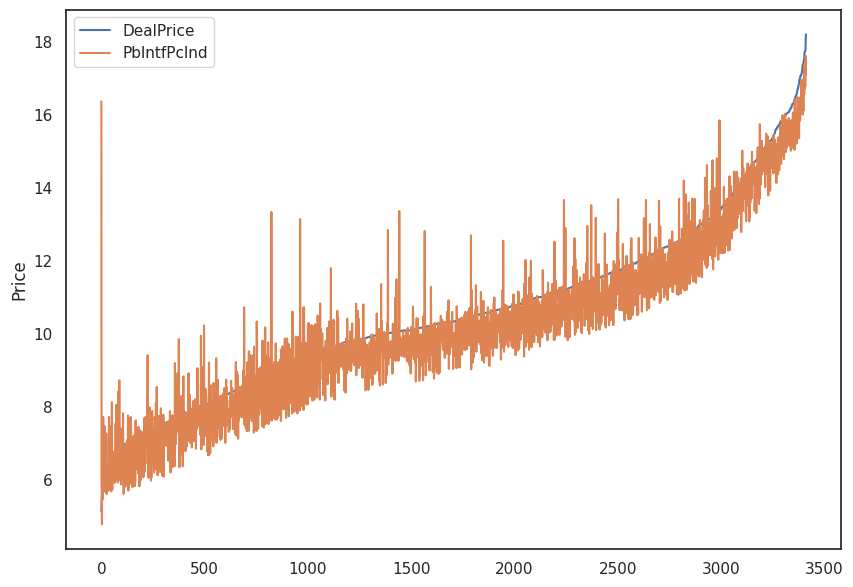

In [10]:
df_price = df[["Price", "PblntfPclnd"]]
df_price = df_price.sort_values("Price").reset_index(drop=True)

plt.subplots(figsize=(10, 7))
sns.lineplot(np.log1p(df_price["Price"]), label="DealPrice")
sns.lineplot(np.log1p(df_price["PblntfPclnd"]), label="PblntfPclnd")

In [11]:
# 범주형 변수에 대한 데이터 분석
categorical = [var for var in df.columns if df[var].dtype=='O']  # 범주형 변수 추출
print(categorical)

['Sido', 'LdCode', 'RegstrSe', 'Lndcgr', 'PrposArea1', 'PrposArea2', 'LadUseSittn', 'TpgrphHg', 'TpgrphFrm', 'RoadSide', 'LandUsePlans']


<Axes: xlabel='Sido', ylabel='Price'>

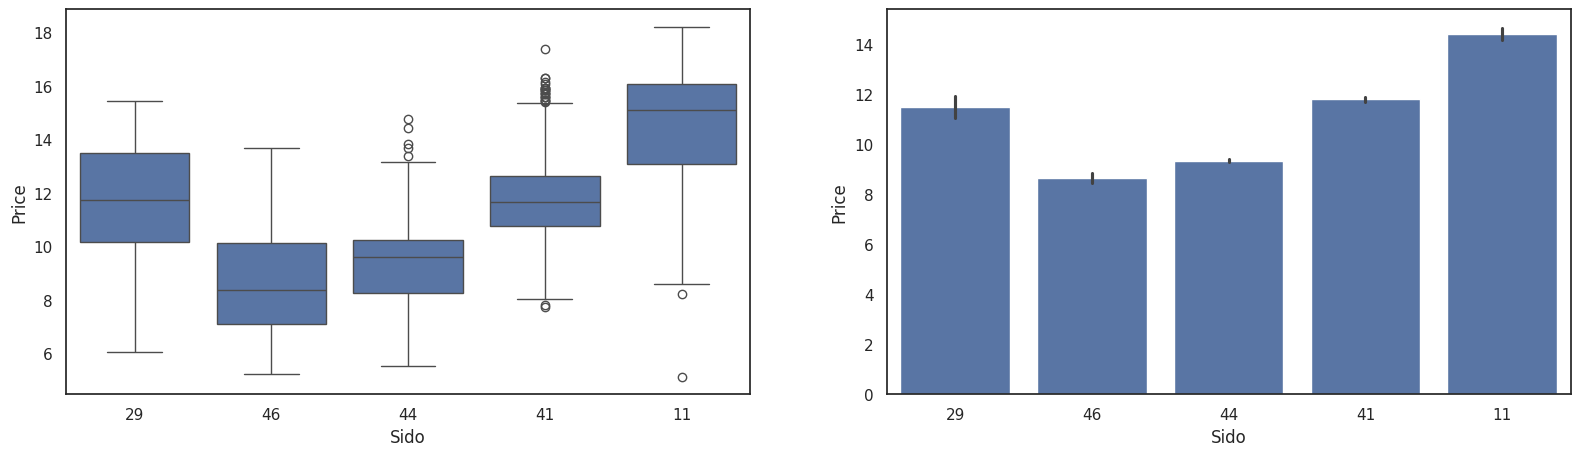

In [12]:
plt.subplots(figsize=(30,5))
plt.clf()
plt.subplot(1, 3, 1)
sns.boxplot(x=df[categorical[0]], y=np.log1p(df["Price"]))
plt.subplot(1, 3, 2)
sns.barplot(x=df[categorical[0]], y=np.log1p(df["Price"]))

In [13]:
# 연속형 변수에 대한 데이터 분석
numerical = [var for var in df.columns if df[var].dtype!="O"]  # 연속형 변수 추출
print(numerical)

['Year', 'Month', 'Price', 'DealArea', 'PblntfPclnd', 'LndpclAr', 'PclndIndex', 'PclndChgRt', 'AcmtlPclndChgRt', 'LargeClPclndIndex', 'LargeClPclndChgRt', 'LargeClAcmtlPclndChgRt', 'PPI', 'CPI', 'MT1', 'MT1_500m', 'MT1_1000m', 'MT1_3000m', 'CS2', 'CS2_500m', 'CS2_1000m', 'CS2_3000m', 'PS3', 'PS3_500m', 'PS3_1000m', 'PS3_3000m', 'SC4', 'SC4_500m', 'SC4_1000m', 'SC4_3000m', 'AC5', 'AC5_500m', 'AC5_1000m', 'AC5_3000m', 'PK6', 'PK6_500m', 'PK6_1000m', 'PK6_3000m', 'OL7', 'OL7_500m', 'OL7_1000m', 'OL7_3000m', 'SW8', 'SW8_500m', 'SW8_1000m', 'SW8_3000m', 'BK9', 'BK9_500m', 'BK9_1000m', 'BK9_3000m', 'CT1', 'CT1_500m', 'CT1_1000m', 'CT1_3000m', 'AG2', 'AG2_500m', 'AG2_1000m', 'AG2_3000m', 'PO3', 'PO3_500m', 'PO3_1000m', 'PO3_3000m', 'AT4', 'AT4_500m', 'AT4_1000m', 'AT4_3000m', 'AD5', 'AD5_500m', 'AD5_1000m', 'AD5_3000m', 'FD6', 'FD6_500m', 'FD6_1000m', 'FD6_3000m', 'CE7', 'CE7_500m', 'CE7_1000m', 'CE7_3000m', 'HP8', 'HP8_500m', 'HP8_1000m', 'HP8_3000m', 'PM9', 'PM9_500m', 'PM9_1000m', 'PM9_300

<Axes: >

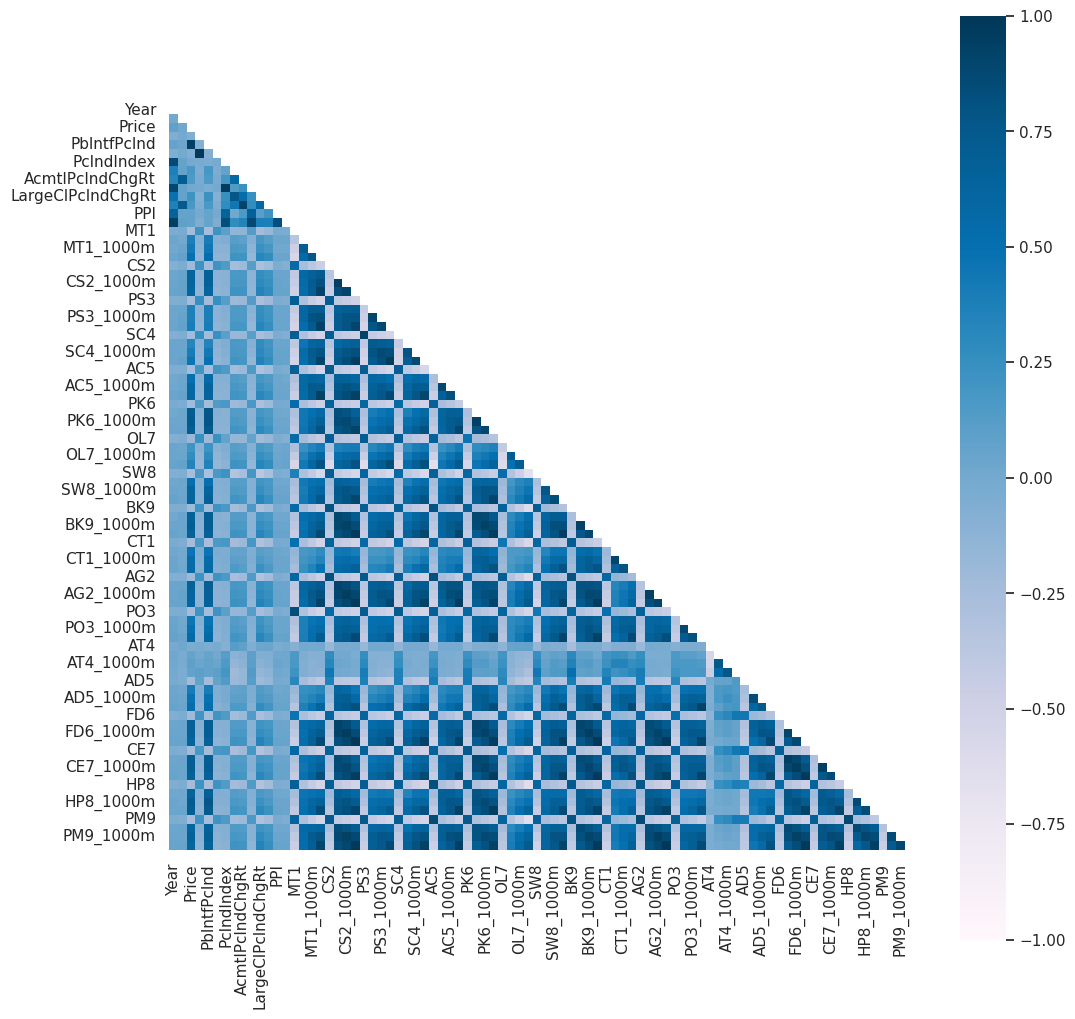

In [14]:
corr = df[numerical].corr(method="pearson")
mask_df = corr
colormap = plt.cm.PuBu

mask = np.zeros_like(mask_df, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
plt.subplots(figsize=(12, 12))
sns.heatmap(
    corr, 
    vmax=1.0,
    vmin=-1.0,
    square=True, 
    mask=mask,
    cmap=colormap, 
    linecolor="white"
)

In [15]:
corr["Price"][corr["Price"].values > 0.5].sort_values(ascending=False)

Price          1.00
PblntfPclnd    0.94
PK6_1000m      0.75
PK6_500m       0.73
HP8_1000m      0.73
CE7_1000m      0.71
PK6_3000m      0.70
HP8_3000m      0.70
CE7_500m       0.70
BK9_1000m      0.70
FD6_500m       0.69
FD6_1000m      0.68
BK9_500m       0.66
PM9_1000m      0.66
CE7_3000m      0.66
BK9_3000m      0.65
AG2_500m       0.65
HP8_500m       0.65
CS2_500m       0.64
AG2_1000m      0.64
FD6_3000m      0.64
SW8_3000m      0.64
CS2_1000m      0.64
SW8_1000m      0.63
PM9_500m       0.62
PM9_3000m      0.62
AG2_3000m      0.62
CS2_3000m      0.60
AC5_3000m      0.60
AC5_1000m      0.60
PO3_3000m      0.56
CT1_3000m      0.56
CT1_1000m      0.55
AD5_3000m      0.53
SW8_500m       0.51
AC5_500m       0.51
MT1_3000m      0.50
Name: Price, dtype: float64

In [16]:
if False:
    for var in numerical:
        print(var)
        sns.jointplot(
            x=var, 
            y="Price", 
            data=df, 
            size=6, 
            kind="scatter",
            color='#800000', 
            space=0
        )
        #print('Correlation:',pearsonr(data[column], data[ycolumn])[0])
        #ax.set_ylabel(ycolumn)
        plt.show()
        print('Number Of Missing Point')
        print(df[var].isna().sum())
        print('**'*30)

## **Data preprocessing**

In [17]:
# 결측치 제거
origin_d = df.isnull().sum()  # 결측치 개수 확인
df = df.dropna()
df = df.reset_index(drop=True)
remove_d = df.isnull().sum()  # 결측치 제거 확인
for k in origin_d.keys():
    print("{:26s} | {:6d} -> {:26s} | {:6d}".format(k, origin_d[k], k, remove_d[k]))

Sido                       |      0 -> Sido                       |      0
LdCode                     |      0 -> LdCode                     |      0
Year                       |      0 -> Year                       |      0
Month                      |      0 -> Month                      |      0
Price                      |      0 -> Price                      |      0
DealArea                   |      0 -> DealArea                   |      0
PblntfPclnd                |      0 -> PblntfPclnd                |      0
RegstrSe                   |      0 -> RegstrSe                   |      0
Lndcgr                     |      0 -> Lndcgr                     |      0
LndpclAr                   |      0 -> LndpclAr                   |      0
PrposArea1                 |      0 -> PrposArea1                 |      0
PrposArea2                 |      0 -> PrposArea2                 |      0
LadUseSittn                |      0 -> LadUseSittn                |      0
TpgrphHg                 

In [18]:
# 범주형 변수에 대한 One-Hot Encoding
categorical.remove("LandUsePlans")  # 토지 이용 상황은 하나의 cell에 범주 값이 여러개 존재하기 때문에, 다른 방식으로 처리해준다.

df = pd.get_dummies(data=df, columns=categorical)  # One-Hot Encoding

# 토지이용계획에 대한 
land_uses_iter = (set(x.split(",")) for x in df["LandUsePlans"])
land_uses_set = sorted(set.union(*land_uses_iter))
land_uses_mat = pd.DataFrame(np.zeros((len(df), len(land_uses_set))), columns=land_uses_set)
for i in range(len(df)):
    land_uses_mat.loc[i, df["LandUsePlans"][i].split("/")] = 1
df = df.join(land_uses_mat.add_prefix("LandUsePlans_"))
df.drop(["LandUsePlans"], axis=1, inplace=True)
df = df.fillna(0.0)

In [19]:
df

,Year,Month,Price,DealArea,PblntfPclnd,LndpclAr,PclndIndex,PclndChgRt,AcmtlPclndChgRt,LargeClPclndIndex,...,LandUsePlans_UNE126(3),LandUsePlans_UNE124(1),LandUsePlans_UBP100(3),LandUsePlans_UQS122(1),LandUsePlans_UQV820(2),LandUsePlans_UQT250(3),LandUsePlans_UQU600(2),LandUsePlans_UQT221(1),LandUsePlans_UNE126(1),LandUsePlans_UMW500(1)
0,2016,6,4544628,1650.30,2381000,1650.30,78.03,0.42,1.70,77.98,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2015,1,359109,4539.00,115000,4539.00,74.52,0.15,0.15,75.03,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2013,3,157303,3590.00,118000,3590.00,72.93,0.09,0.20,73.54,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,2014,6,181500,4000.00,139100,4000.00,72.33,0.10,0.47,74.36,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,2020,6,500000,4000.00,215000,4000.00,92.34,0.35,2.30,92.76,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3406,2020,3,20236,7128.20,14400,7128.20,95.15,0.11,0.36,93.49,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3407,2021,5,32663,8246.20,17800,8246.20,97.29,0.22,1.10,96.16,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3408,2021,4,23825,10283.00,14500,10283.00,97.08,0.23,0.88,95.94,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3409,2021,4,25999,6656.60,16100,6656.60,97.08,0.23,0.88,95.94,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [20]:
# 연속형 변수에 대한 이상치 제거
# 연속형 변수를 정규분포를 따르는지에 대한 Kolmoogorov-Smirnov Test를 수행
for n in numerical:
    ks_test = kstest(df[n], "norm", args=(df[n].mean(), df[n].var()**0.5))
    print("{:26s}| statistic = {:.8f}, pvalue = {:.8f}".format(n, ks_test.statistic, ks_test.pvalue))

Year                      | statistic = 0.13854483, pvalue = 0.00000000
Month                     | statistic = 0.10934032, pvalue = 0.00000000
Price                     | statistic = 0.41370381, pvalue = 0.00000000
DealArea                  | statistic = 0.36105033, pvalue = 0.00000000
PblntfPclnd               | statistic = 0.40824196, pvalue = 0.00000000
LndpclAr                  | statistic = 0.36060061, pvalue = 0.00000000
PclndIndex                | statistic = 0.06719124, pvalue = 0.00000000
PclndChgRt                | statistic = 0.04226166, pvalue = 0.00000989
AcmtlPclndChgRt           | statistic = 0.10939069, pvalue = 0.00000000
LargeClPclndIndex         | statistic = 0.08002270, pvalue = 0.00000000
LargeClPclndChgRt         | statistic = 0.04695203, pvalue = 0.00000057
LargeClAcmtlPclndChgRt    | statistic = 0.10707821, pvalue = 0.00000000
PPI                       | statistic = 0.24164114, pvalue = 0.00000000
CPI                       | statistic = 0.11314533, pvalue = 0.0

결과를 확인해보면 연속형 변수 모두 p-value가 낮아(0.00000000) 높은 유의수준에서 귀무가설을 기각함을 확인할 수 있습니다.

it is evident that the p-values for all numerical variables are very low(0.00000000), leading to the rejection of the null hypothesis at a high level of significance.

In [21]:
# Divided train & test dataset
x = df.drop(["Price"], axis=1)
y = df["Price"]

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.3, random_state = 0)
print('Train Dataset:', train_x.shape, '\nTest Dataset:', test_x.shape)

train_y = train_y.to_numpy().astype(int)
test_y = test_y.to_numpy().astype(int)

Train Dataset: (2387, 4886) 
Test Dataset: (1024, 4886)


### **Model Training with XGBoost**

In [22]:


parameter = {
    'learning_rate':0.22,
    'n_estimators':350,
    'max_depth':9,
    'min_child_weight':1,
    'gamma':0,
    'subsample':0.91,
    'colsample_bytree':0.89,
    'lambda':10,
    'alpha':5,
    'eval_metric':'rmse',
    'seed':0
}
    
model = xgb.XGBRegressor(
    tree_method = "hist",
    device = "cuda",
    importance_type = 'gain',
    learning_rate = parameter['learning_rate'],
    n_estimators = parameter['n_estimators'], 
    max_depth = parameter['max_depth'],
    min_child_weight = parameter['min_child_weight'],
    gamma = parameter['gamma'],
    subsample = parameter['subsample'],
    colsample_bytree = parameter['colsample_bytree'],
    reg_lambda = parameter['lambda'],
    alpha = parameter['alpha'],
    eval_metric = parameter['eval_metric'],
    seed = parameter['seed']
)

model.fit(train_x, train_y)

XGBRegressor(alpha=5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.89, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0, grow_policy=None, importance_type='gain',
             interaction_constraints=None, learning_rate=0.22, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=350, n_jobs=None,
             num_parallel_tree=None, ...)

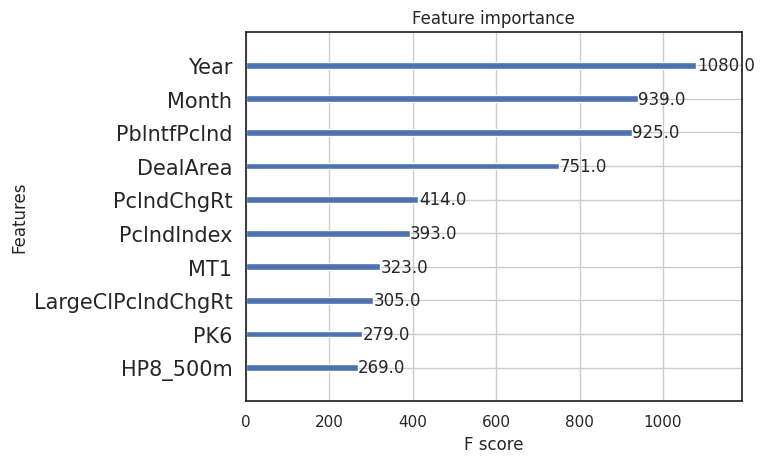

In [23]:
plot_importance(model, max_num_features=10)

plt.yticks(fontsize=15)
plt.show()

### **Evaluation and Validation**

In [24]:
relation_square = model.score(train_x, train_y)
print("R-Squared: ", relation_square)

predict_y = model.predict(test_x)
#predict_y = np.exp(predict_y_log) - 1
#test_y = np.exp(test_y) - 1
result = pd.DataFrame({'pred' : predict_y, 'real' : test_y})
print("RMSE score: {:,.0f}".format(mean_squared_error(test_y, predict_y) ** 0.5))

result['ratio(%)'] = (abs(result['pred'] - result['real']) / result['real']) * 100

/usr/anaconda3/envs/lvpm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:14:05] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


R-Squared:  0.999999781204851
RMSE score: 2,114,925


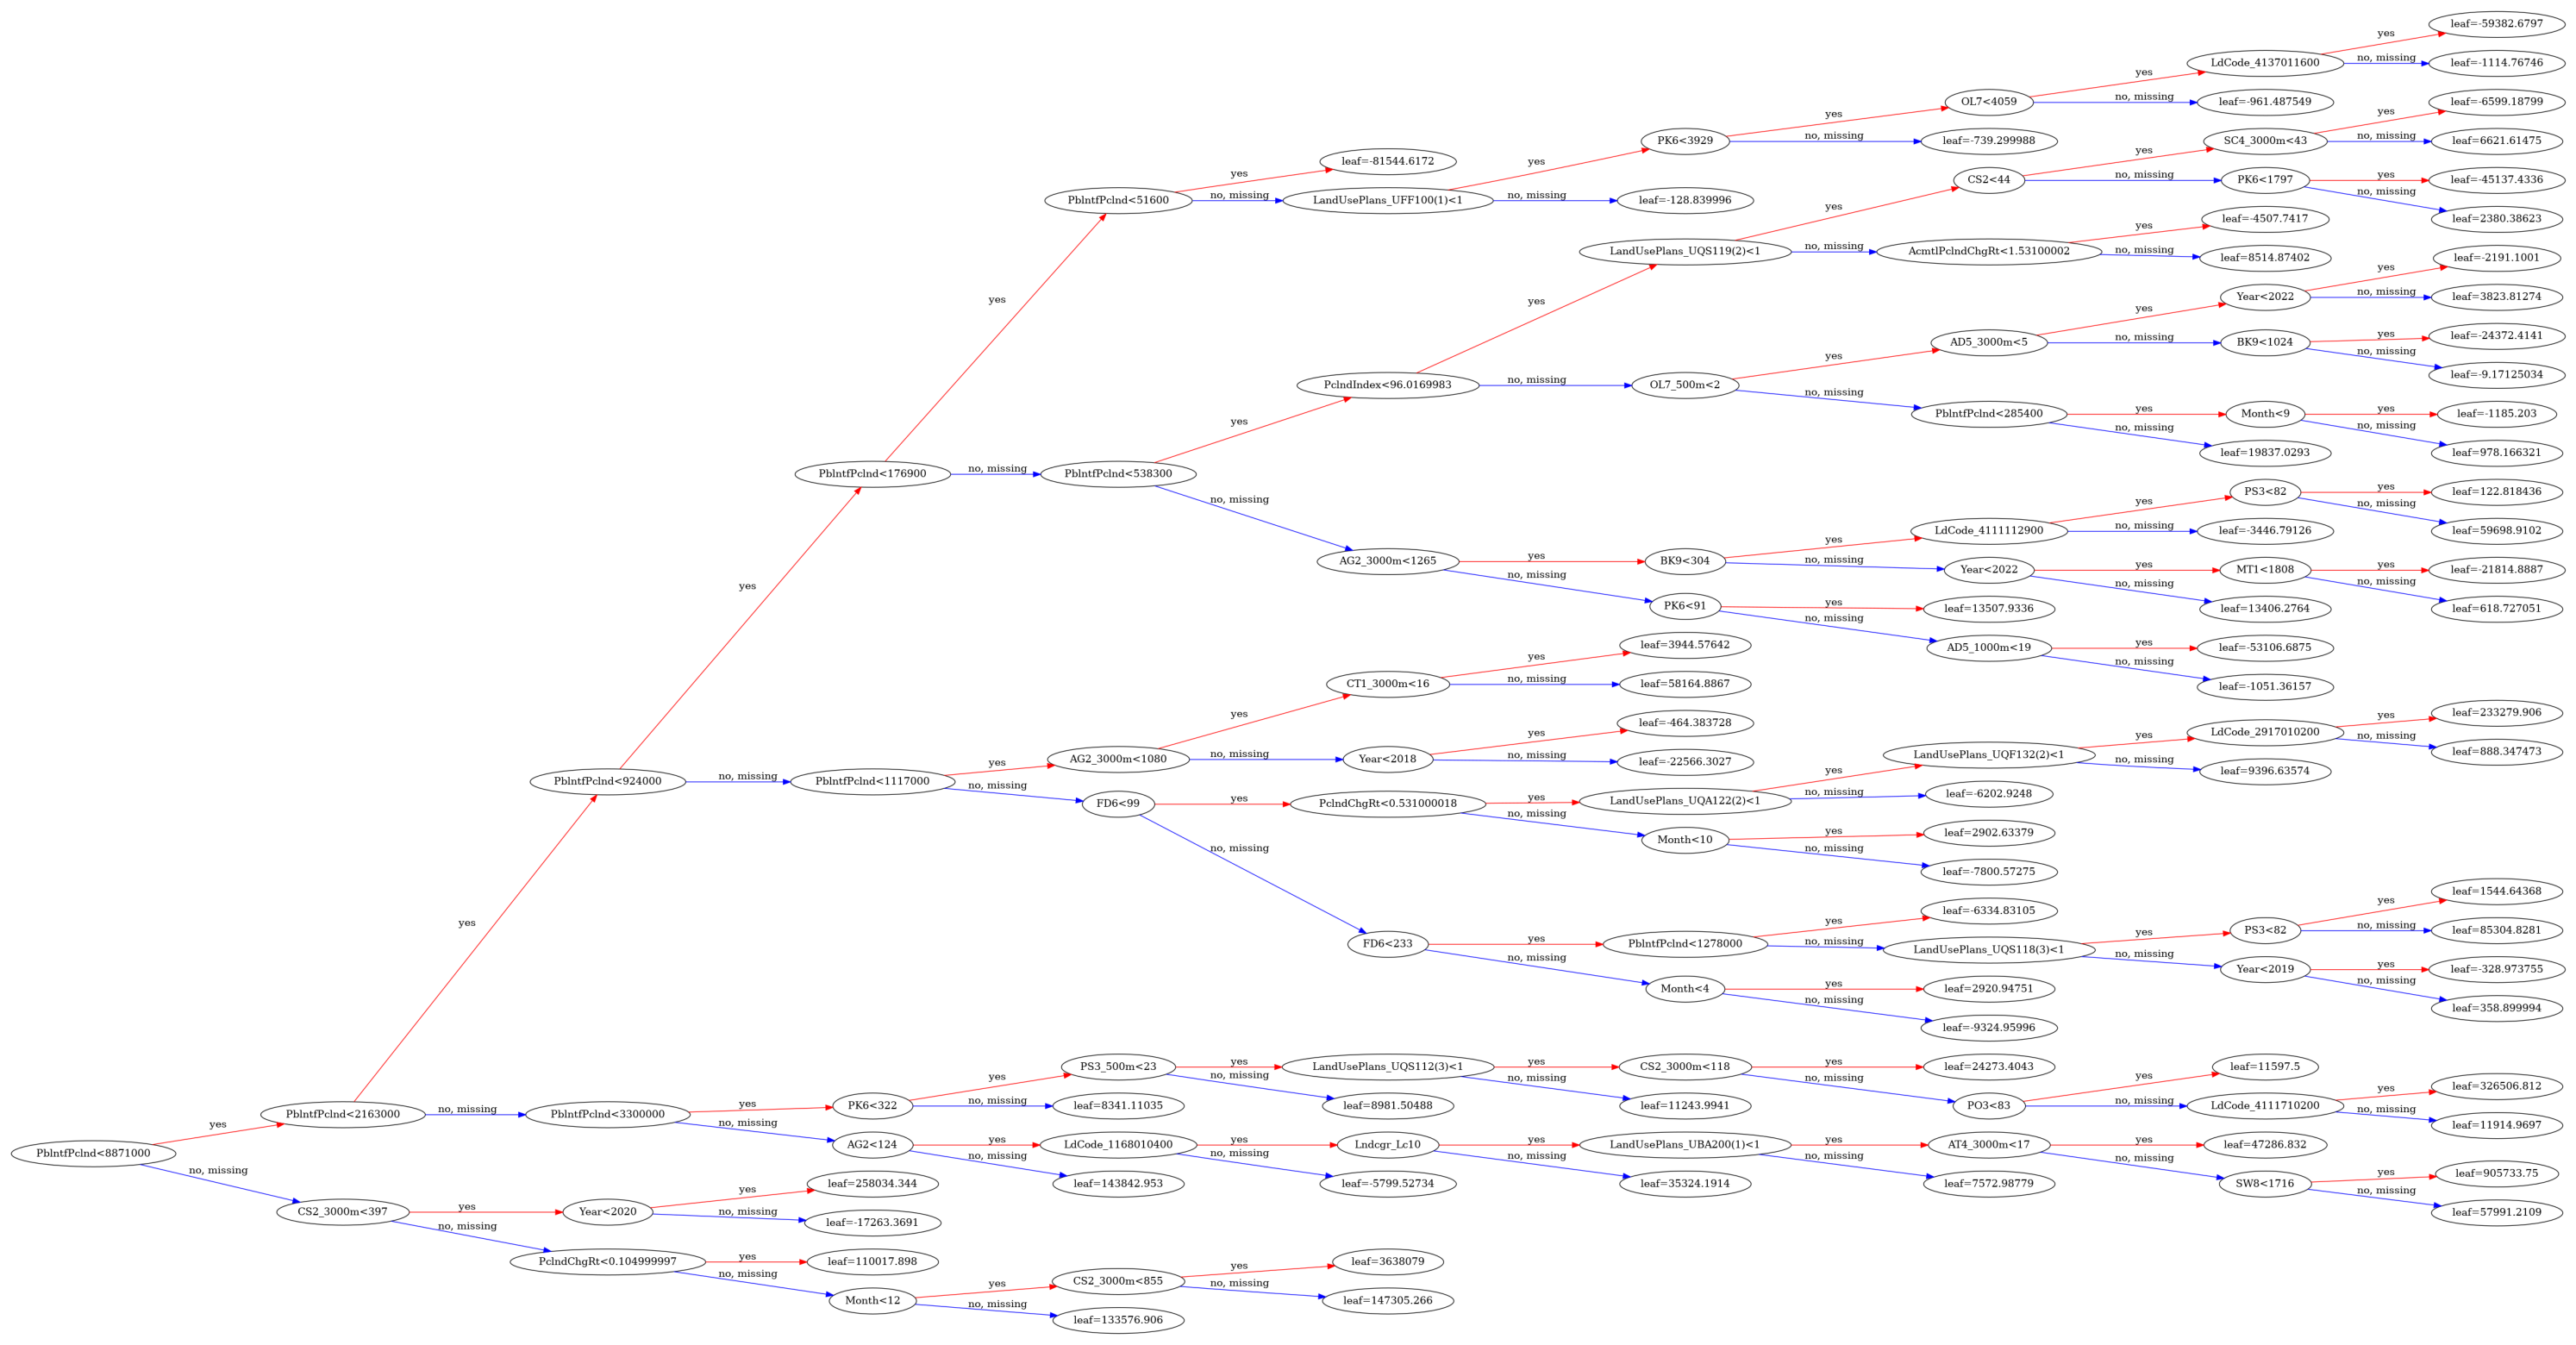

In [25]:
# Model visualization
fig, ax = plt.subplots(figsize=(100, 20))
xgb.plot_tree(model, num_trees=4, rankdir='LR', ax=ax)
plt.show()

In [26]:
print(result.sort_values("ratio(%)"))
for r in [3, 5, 10, 20]:
    print("ratio < {:2d}%: {:5d} / {:5d} ({:4.2f}%)".format(
        r, len(result[result["ratio(%)"] < r]), len(result), len(result[result["ratio(%)"] < r])/len(result)*100
    ))

           pred    real  ratio(%)
375   347455.75  347394      0.02
211     9956.06    9940      0.16
830   142493.88  143000      0.35
956    66816.56   66548      0.40
178    44280.19   44467      0.42
..          ...     ...       ...
458   806326.12   23658   3308.26
310   105044.31    2334   4400.61
252   590565.38   11418   5072.23
866  2743822.75   44961   6002.67
701  2114845.50   22471   9311.44

[1024 rows x 3 columns]
ratio <  3%:    45 /  1024 (4.39%)
ratio <  5%:    75 /  1024 (7.32%)
ratio < 10%:   137 /  1024 (13.38%)
ratio < 20%:   271 /  1024 (26.46%)


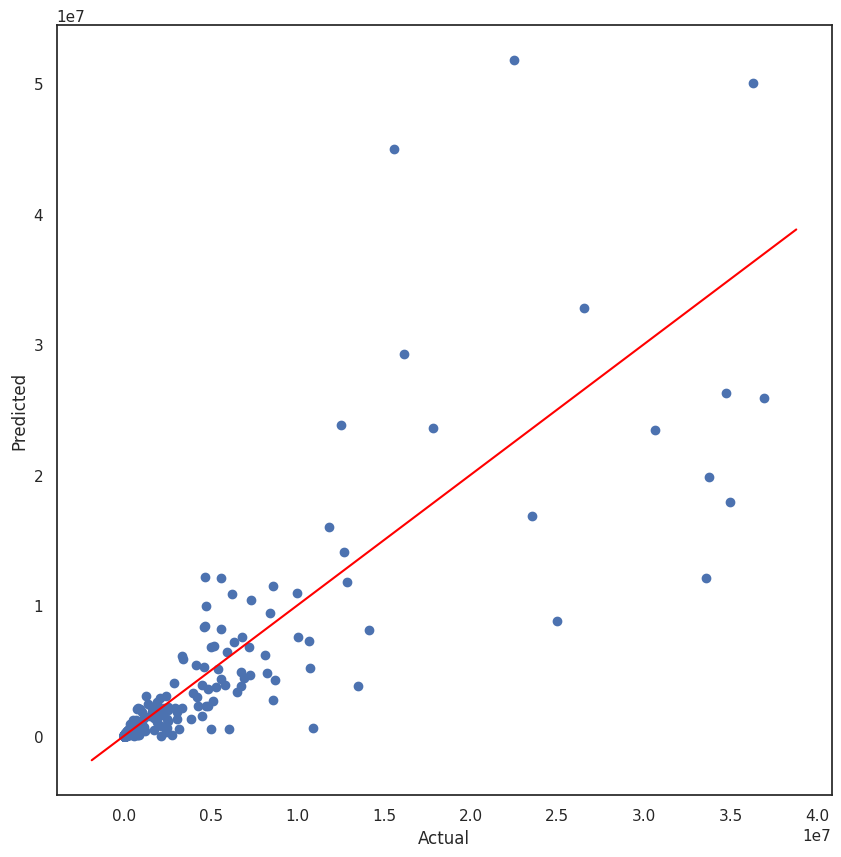

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(data=result, x="pred", y="real")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x,color='red')
plt.show()

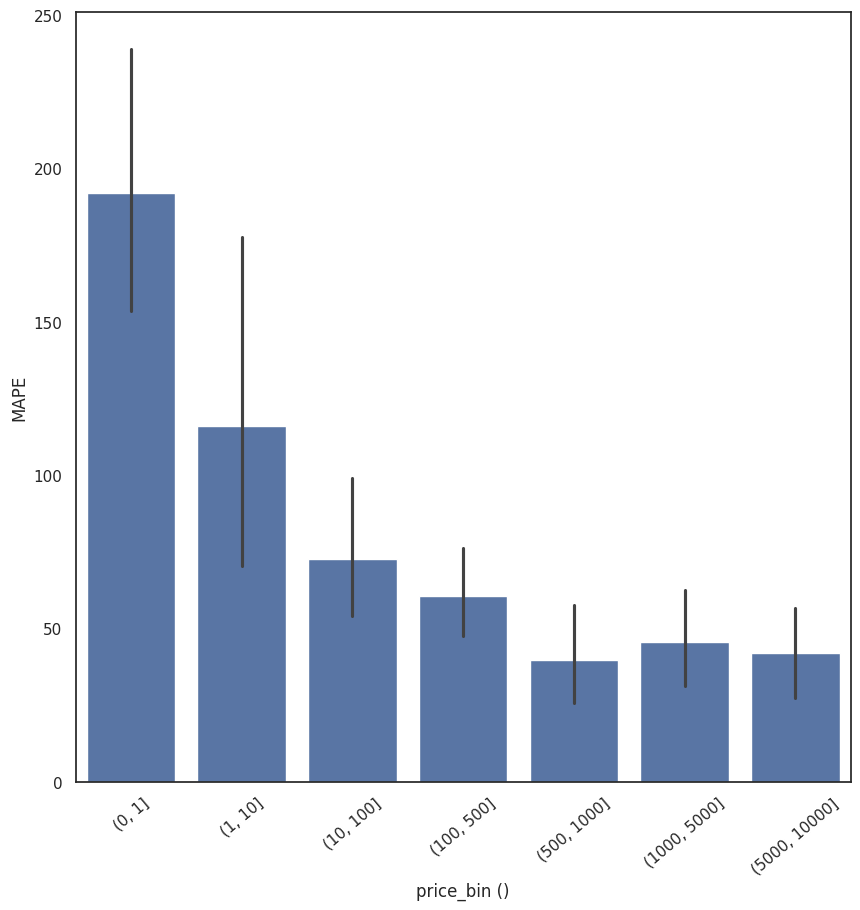

In [28]:
price_bin = pd.cut(test_y/10000,bins=[0,1,10,100,500,1000,5000,10000])
mape = result["ratio(%)"]

fig,ax = plt.subplots(1,figsize=(10,10))
sns.barplot(x=price_bin, y=mape)
ax.set_ylabel('MAPE')
ax.set_xlabel('price_bin ()')
plt.xticks(rotation=40)
plt.show()

In [29]:
price_bin

[(1, 10], (1, 10], (0, 1], (100, 500], (1, 10], ..., (1, 10], (0, 1], (100, 500], (1, 10], (10, 100]]
Length: 1024
Categories (7, interval[int64, right]): [(0, 1] < (1, 10] < (10, 100] < (100, 500] < (500, 1000] < (1000, 5000] < (5000, 10000]]

<Axes: xlabel='ratio(%)', ylabel='Density'>

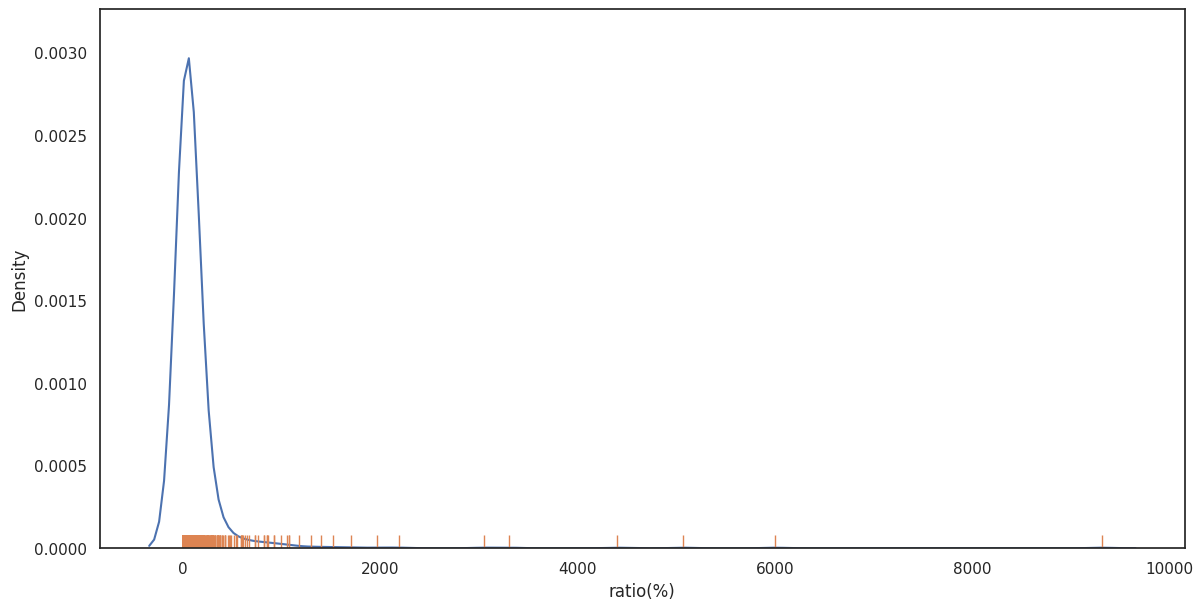

In [30]:
fig = plt.subplots(figsize=(14, 7))
sns.kdeplot(result["ratio(%)"])
sns.rugplot(result["ratio(%)"])

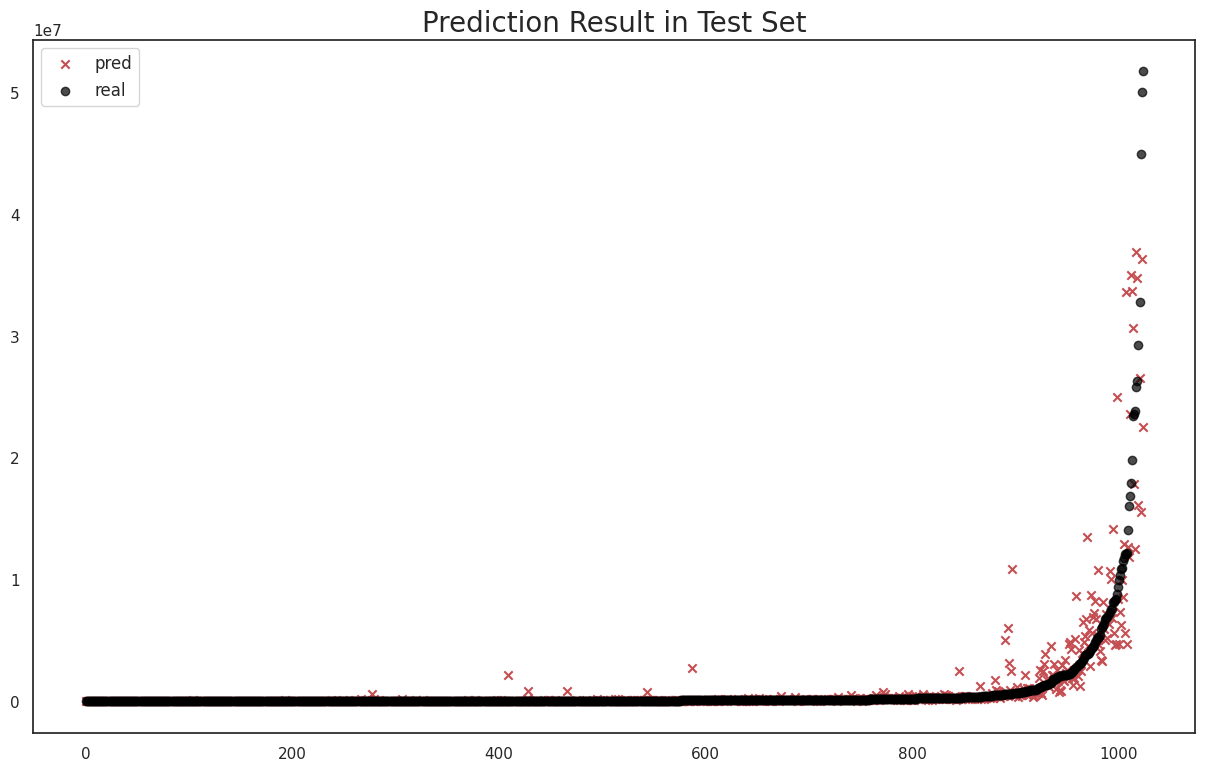

In [31]:
result = result.sort_values(by='real').reset_index(drop=True)

plt.figure(figsize=(15, 9))
plt.scatter(result.index, result['pred'], marker='x', color='r')
plt.scatter(result.index, result['real'], alpha=0.7, marker='o', color='black')
plt.title("Prediction Result in Test Set", fontsize=20)
plt.legend(['pred', 'real'], fontsize=12)
plt.show()

In [33]:
import src.data.convert_code as cc
cc.PLACE_CODE.keys() 

dict_keys(['MT1', 'CS2', 'PS3', 'SC4', 'AC5', 'PK6', 'OL7', 'SW8', 'BK9', 'CT1', 'AG2', 'PO3', 'AT4', 'AD5', 'FD6', 'CE7', 'HP8', 'PM9'])

In [43]:
import src.data.convert_code as cc

index = 88

pd.set_option('display.max_rows',None) # 전체 행 출력하기
land_info_str = f"평가된 토지 예측가: {abs(int(predict_y[index]))}원/㎡당\n\n"
land_use_plan_str = "== 토지 정보 ==\n"
place_info_str = "== 주변 상권 정보 ==\n"
for k, v in test_x.iloc[88].items():
    if v == 0.0:
        continue
    if k[0:3] in cc.PLACE_CODE.keys():
        place_kr = cc.PLACE_CODE[k[0:3]]
        if len(k.split("_")) == 2:
            place_info_str += "{} 이내에 있는 {}의 수: {}\n".format(k.split("_")[1], place_kr, v)
        else:
            if v == 20000:
                continue
            place_info_str += "{} 최소 거리: {}\n".format(place_kr, v)
    elif len(k.split("_")) == 2:
        if k.split("_")[0] == "LdCode":
            jibun = cc.code2addr(k.split("_")[1])
            land_info_str += f"지번주소: {jibun}\n"
        if k.split("_")[0] == "RegstrSe":
            re = cc.code2regstr(k.split("_")[1][2:3])
            land_info_str += f"필지: {re}\n"
        if k.split("_")[0] == "Lndcgr":
            lc = cc.code2lndcgr(k.split("_")[1][2:4])
            land_info_str += f"지목: {lc}\n"
        if k.split("_")[0] == "PrposArea1":
            a1 = cc.code2zoning(k.split("_")[1][2:4])
            land_info_str += f"용도지역: {a1}\n"
        if k.split("_")[0] == "LadUseSittn":
            us = cc.code2landcategory(k.split("_")[1][2:5])
            land_info_str += f"이용상황: {us}\n"
        if k.split("_")[0] == "TpgrphHg":
            th = cc.code2tpgrphhg(k.split("_")[1][2:4])
            land_info_str += f"토지지세: {th}\n"
        if k.split("_")[0] == "TpgrphFrm":
            tf = cc.code2tpgrphfrm(k.split("_")[1][2:4])
            land_info_str += f"토지형상: {tf}\n"
        if k.split("_")[0] == "TpgrphHg":
            rs = cc.code2roadside(k.split("_")[1][2:4])
            land_info_str += f"도로접면: {rs}\n"
        if k.split("_")[0] == "LandUsePlans":
            land_use_plan_str += cc.code2useplan(k.split("_")[1]) + ", "
    # print(f"- {k}: {v}")

land_info_str += "토지면적: {:,}㎡\n".format(test_x.iloc[index]["LndpclAr"])
land_info_str += "기준년도: {}년\n".format(test_x.iloc[index]["Year"])
land_info_str += "기준월: {}월\n".format(test_x.iloc[index]["Month"])
land_info_str += "개별공시지가: {:,}원/㎡당\n".format(test_x.iloc[index]["PblntfPclnd"])
land_info_str += "지가지수: {}\n".format(test_x.iloc[index]["PclndIndex"])
land_info_str += "지가변동률: {}%\n".format(test_x.iloc[index]["PclndChgRt"])
land_info_str += "누계지가변동률: {}%\n".format(test_x.iloc[index]["AcmtlPclndChgRt"])
land_info_str += "권역별지가지수: {}\n".format(test_x.iloc[index]["LargeClPclndIndex"])
land_info_str += "권역별지가변동률: {}%\n".format(test_x.iloc[index]["LargeClPclndChgRt"])
land_info_str += "권역별누계지가변동률: {}%\n".format(test_x.iloc[index]["LargeClAcmtlPclndChgRt"])
land_info_str += "생산자물가지수: {}\n".format(test_x.iloc[index]["PPI"])
land_info_str += "소비자물가지수: {}\n".format(test_x.iloc[index]["CPI"])

land_info_str += f"이용계획: {land_use_plan_str[:-2]}"

info_str = land_info_str + "\n\n" + place_info_str

print(info_str)

평가된 토지 예측가: 49180원/㎡당

지번주소: 경기도 평택시 청북읍 어소리
필지: 일반
지목: 답
용도지역: 농림지역
이용상황: 답
토지지세: 평지
도로접면: 광대소각
토지형상: 세로장방
토지면적: 4,066.0㎡
기준년도: 2016년
기준월: 1월
개별공시지가: 39,500원/㎡당
지가지수: 72.702
지가변동률: 0.116%
누계지가변동률: 0.116%
권역별지가지수: 77.577
권역별지가변동률: 0.088%
권역별누계지가변동률: 0.088%
생산자물가지수: 97.56
소비자물가지수: 95.232
이용계획: == 토지 정보 ==
가축사육제한구역<포함>, 농림지역<포함>, 농업진흥구역<포함>

== 주변 상권 정보 ==
대형마트 최소 거리: 2380
3000m 이내에 있는 대형마트의 수: 1
편의점 최소 거리: 848
1000m 이내에 있는 편의점의 수: 1
3000m 이내에 있는 편의점의 수: 31
어린이집 및 유치원 최소 거리: 1615
3000m 이내에 있는 어린이집 및 유치원의 수: 3
학교 최소 거리: 1249
3000m 이내에 있는 학교의 수: 3
학원 최소 거리: 4332
주차장 최소 거리: 1631
3000m 이내에 있는 주차장의 수: 5
주유소 및 충전소 최소 거리: 1133
3000m 이내에 있는 주유소 및 충전소의 수: 15
지하철역 최소 거리: 8466
은행 최소 거리: 972
1000m 이내에 있는 은행의 수: 1
3000m 이내에 있는 은행의 수: 18
문화시설 최소 거리: 2431
3000m 이내에 있는 문화시설의 수: 1
중개업소 최소 거리: 1033
3000m 이내에 있는 중개업소의 수: 37
공공기관 최소 거리: 2401
3000m 이내에 있는 공공기관의 수: 3
관광명소 최소 거리: 1497
3000m 이내에 있는 관광명소의 수: 8
숙박 최소 거리: 2500
3000m 이내에 있는 숙박의 수: 1
음식점 최소 거리: 909
1000m 이내에 있는 음식점의 수: 6
3000m 이내에 있는 음식점의 수: 130
카페 

In [44]:
print("토지 예측가: {:,d}원\n실제 거래가: {:,d}원".format(int(predict_y[index]), test_y[index]))

토지 예측가: 49,180원
실제 거래가: 46,888원


In [45]:
from src.llm import land_appraisal

sys_msg_str = """
    너는 이제부터 토지의 가치를 평가하는 감정평가사야. 주어진 정보를 바탕으로 평가된 토지 가격이 어떻게 산출되었는지 논리적으로 설명해야해.
    모든 설명을 마치고 마지막에는 제곱미터당 가격과 토지면적과 곱한 가격을 모두 말해줘야해.
    
    
"""

sys_msg_str = """
    너는 이제부터 토지의 가치를 평가하는 감정평가사야. 주어진 정보를 바탕으로 평가된 토지 가격이 어떻게 산출되었는지 논리적으로 설명해야해.
    모든 설명을 마치고 마지막에는 제곱미터당 가격과 토지면적과 곱한 가격을 모두 말해줘야해.
    
    되도록 아래 양식에 맞추어 토지 평가를 해줘.
    
    소재지: 울산광역시 울주군 서생면 화산리 935-6
    지목: 임야
    면적: 2,050㎡
    용도지역: 자연녹지
    이용상황: 건축허가부지 등
    도로조건: 소로한면
    형상지세: 부정형/완경사
    개별공시지가: 15,900원
    
    대상 물건에 대하여 2021년 5월 기준으로 
    
"""

result = land_appraisal.create(land_info=info_str, sys_msg=sys_msg_str)

In [46]:
print(result)

이 토지는 경기도 평택시 청북읍 어소리에 위치하고 있고, 필지는 일반 답이며 용도지역은 농림지역입니다. 도로접면은 광대소각, 토지지세는 평지인 것으로 보아 교통이 그나마 원활하며 활용성이 높을 것으로 보입니다.

그러나 이 토지는 가축사육제한구역, 농림지역, 농업진흥구역에 포함되어 있어 일부 제한적인 용도가 존재하는 것으로 보입니다. 이러한 제한적인 용도는 토지 가치를 절하시킬 수 있습니다.

주변 상권 정보를 살펴보면, 가장 가까운 대형마트와 편의점까지의 거리는 각각 2380m, 848m이며, 각각 1개, 31개가 3000m 이내에 위치하고 있습니다. 은행, 주유소, 중개업소 등 필수적인 시설들이 어느 정도는 주변에 분포하고 있으나, 학교, 유치원, 병원 등이 멀리 떨어져 있어 가치가 인하될 수 있습니다.

여기에 기준년도 2016년, 기준월 1월의 개별공시지가가 39,500원/㎡이며, 이를 반영했을 때의 지가지수는 72.702, 지가변동률은 0.116%, 누계지가변동률은 0.116%, 권역별지가지수는 77.577, 권역별지가변동률과 누계변동률은 각각 0.088%입니다.

손톱조차 모르는 주변의 경제 상황이 움직임에도 불구하고 이 토지의 가치가 꾸준히 상향 평가되고 있다는 것을 보여주며, 이는 투자 가능성을 암시하고 있습니다.

결과적으로, 이 토지의 가치는 각종 인프라가 어느정도 갖춰져 있고, 일부 제한적인 용도에도 불구하고 꾸준한 투자 가능성이 있어서 평가액은 49180원/㎡로 산출되었습니다.

따라서 이 토지의 총 가격은 제곱미터당 가격인 49180원을 토지면적인 4066㎡와 곱한 가격인 199,724,280원입니다.
